In [1]:
# --- FOR DATA PREPROCESSING AND CLASS IMBALANCE ---

In [23]:
import os
import shutil
import json
import yaml
import numpy
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict

In [20]:
PROJECT_ROOT = Path("..").resolve()

# Sources (your raw FLIR folders)
TRAIN_SRC = PROJECT_ROOT / "images_thermal_train"   # contains data/ and coco.json
VAL_SRC   = PROJECT_ROOT / "images_thermal_val"     # contains data/ and coco.json

# Dest YOLO structure
IMAGES_DIR = PROJECT_ROOT / "images"
LABELS_DIR = PROJECT_ROOT / "labels"

# Your config.yml with names:
CONFIG_YAML = PROJECT_ROOT / "config.yml"

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp")
SKIP_EXISTING = False  # set True to speed up re-runs
VERIFY_FILES = True

In [21]:
# --- MAKING THE YOLO DATA FILES STRUCTURE ---
def make_yolo_dirs():
    (IMAGES_DIR / "train").mkdir(parents=True, exist_ok=True)
    (IMAGES_DIR / "val").mkdir(parents=True, exist_ok=True)
    (LABELS_DIR / "train").mkdir(parents=True, exist_ok=True)
    (LABELS_DIR / "val").mkdir(parents=True, exist_ok=True)

make_yolo_dirs()
print("✓ YOLO directory structure ready")


✓ YOLO directory structure ready


In [24]:
# --- COPYING ALL IMAGE DATAS TO THE YOLO DIRECTORIES --- 
def copy_images(src_dataset_dir: Path, split: str):
    src_img_dir = src_dataset_dir / "data"
    dst_img_dir = IMAGES_DIR / split

    if dst_img_dir.exists() and not SKIP_EXISTING:
        shutil.rmtree(dst_img_dir)
        dst_img_dir.mkdir(parents=True, exist_ok=True)

    files = sorted([p for p in src_img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
    copied, skipped = 0, 0

    for p in files:
        dst = dst_img_dir / p.name
        if SKIP_EXISTING and dst.exists():
            skipped += 1
            continue
        shutil.copy2(p, dst)
        copied += 1

    print(f"✓ {split}: copied {copied} images" + (f" (skipped {skipped})" if skipped else ""))
    return [p.name for p in files]

train_image_files = copy_images(TRAIN_SRC, "train")
val_image_files   = copy_images(VAL_SRC, "val")

print(f"Have {len(train_image_files)} training images")
print(f"Have {len(val_image_files)} val/test images")


✓ train: copied 10742 images
✓ val: copied 1144 images
Have 10742 training images
Have 1144 val/test images


In [25]:
# --- CONVERT COCO -> YOLO LABELS ---
def load_names_from_config(config_path: Path):
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)
    names = [str(n).lower().strip() for n in cfg["names"]]
    return names

def coco_to_yolo_labels(src_dataset_dir: Path, split: str, image_files_filter=None):
    coco_path = src_dataset_dir / "coco.json"
    assert coco_path.exists(), f"Missing {coco_path}"

    names = load_names_from_config(CONFIG_YAML)
    name_to_idx = {n: i for i, n in enumerate(names)}

    with open(coco_path, "r") as f:
        data = json.load(f)

    # Map category_id -> yolo_class_idx using category name match to config.yml
    catid_to_idx = {}
    unmatched = []
    for cat in data["categories"]:
        cname = str(cat["name"]).lower().strip()
        if cname in name_to_idx:
            catid_to_idx[cat["id"]] = name_to_idx[cname]
        else:
            unmatched.append(cname)
    if unmatched:
        print(f"Note: {split}: {len(set(unmatched))} COCO categories not in config.yml (skipped).")

    # Images by id
    images = {img["id"]: img for img in data["images"]}

    # Optional filter (keep only images we copied)
    if image_files_filter is not None:
        keep = set(image_files_filter)
        images = {iid: info for iid, info in images.items() if Path(info["file_name"]).name in keep}

    # Group annotations by image_id
    ann_by_img = defaultdict(list)
    for anno in data["annotations"]:
        if anno["image_id"] in images:
            ann_by_img[anno["image_id"]].append(anno)

    dst_label_dir = LABELS_DIR / split
    if dst_label_dir.exists() and not SKIP_EXISTING:
        shutil.rmtree(dst_label_dir)
        dst_label_dir.mkdir(parents=True, exist_ok=True)

    processed, empty = 0, 0

    for img_id, img_info in images.items():
        w, h = img_info["width"], img_info["height"]
        img_name = Path(img_info["file_name"]).name
        label_name = Path(img_name).with_suffix(".txt").name
        out_path = dst_label_dir / label_name

        if SKIP_EXISTING and out_path.exists():
            processed += 1
            continue

        lines = []
        for anno in ann_by_img.get(img_id, []):
            cid = anno["category_id"]
            if cid not in catid_to_idx:
                continue

            x, y, bw, bh = anno["bbox"]

            # Basic sanity checks
            if bw <= 0 or bh <= 0:
                continue

            xc = (x + bw / 2.0) / w
            yc = (y + bh / 2.0) / h
            bw_n = bw / w
            bh_n = bh / h

            # Valid normalized bounds
            if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 < bw_n <= 1 and 0 < bh_n <= 1):
                continue

            cls = catid_to_idx[cid]
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {bw_n:.6f} {bh_n:.6f}\n")

        out_path.write_text("".join(lines))
        if len(lines) == 0:
            empty += 1
        processed += 1

    print(f"✓ {split}: wrote {processed} label files ({empty} empty allowed)")

coco_to_yolo_labels(TRAIN_SRC, "train", image_files_filter=train_image_files)
coco_to_yolo_labels(VAL_SRC, "val", image_files_filter=val_image_files)


Note: train: 65 COCO categories not in config.yml (skipped).
✓ train: wrote 10742 label files (264 empty allowed)
Note: val: 65 COCO categories not in config.yml (skipped).
✓ val: wrote 1144 label files (16 empty allowed)


In [26]:
# -- Verify IMAGE AND LABEL PAIRS -- 
def verify_pairs(split: str):
    img_dir = IMAGES_DIR / split
    lbl_dir = LABELS_DIR / split

    img_stems = {p.stem for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS}
    lbl_stems = {p.stem for p in lbl_dir.iterdir() if p.suffix.lower() == ".txt"}

    missing_labels = img_stems - lbl_stems
    missing_images = lbl_stems - img_stems

    if missing_labels:
        print(f"⚠ {split}: {len(missing_labels)} images without labels (examples: {list(missing_labels)[:5]})")
    if missing_images:
        print(f"⚠ {split}: {len(missing_images)} labels without images (examples: {list(missing_images)[:5]})")

    if not missing_labels and not missing_images:
        print(f"✓ {split}: all {len(img_stems)} images have matching labels")

if VERIFY_FILES:
    verify_pairs("train")
    verify_pairs("val")


✓ train: all 10742 images have matching labels
✓ val: all 1144 images have matching labels


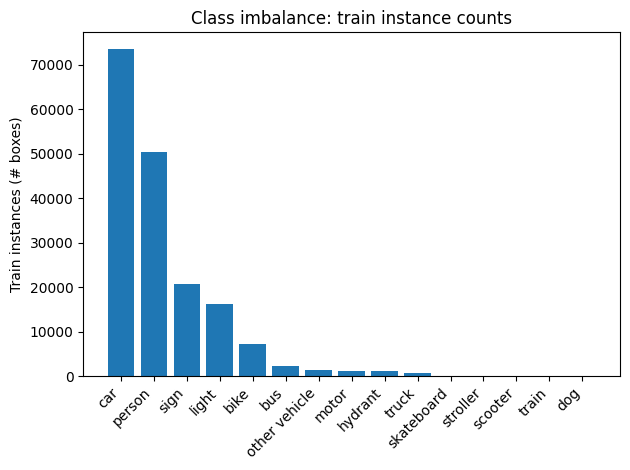

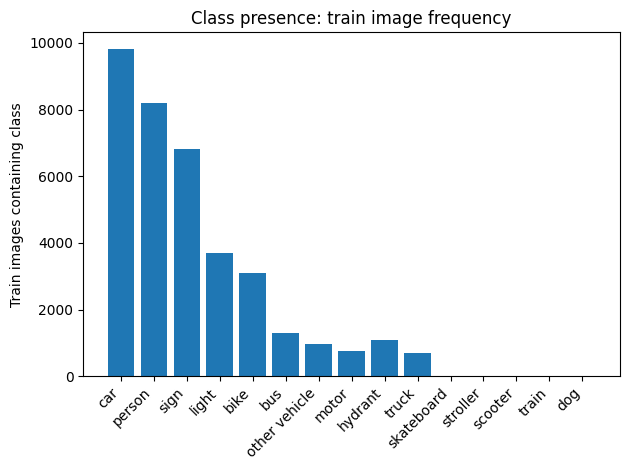

Top classes by instances:
            car: 73623 instances, 9824 images
         person: 50478 instances, 8205 images
           sign: 20770 instances, 6802 images
          light: 16198 instances, 3695 images
           bike: 7237 instances, 3096 images
            bus: 2245 instances, 1296 images
  other vehicle: 1373 instances, 953 images
          motor: 1116 instances, 744 images
        hydrant: 1095 instances, 1075 images
          truck: 829 instances, 708 images


In [27]:
def class_counts_from_yolo_labels(label_dir: Path, names):
    counts = Counter()
    images_with_class = Counter()

    for txt in label_dir.glob("*.txt"):
        # Each line: cls x y w h
        lines = txt.read_text().strip().splitlines()
        present = set()
        for ln in lines:
            if not ln.strip():
                continue
            cls = int(ln.split()[0])
            counts[cls] += 1
            present.add(cls)
        for cls in present:
            images_with_class[cls] += 1

    # Ensure all classes appear (even if 0)
    for i in range(len(names)):
        counts[i] += 0
        images_with_class[i] += 0

    return counts, images_with_class

names = load_names_from_config(CONFIG_YAML)
counts, imgfreq = class_counts_from_yolo_labels(LABELS_DIR / "train", names)

# Sort by count descending for readability
order = sorted(range(len(names)), key=lambda i: counts[i], reverse=True)
labels = [names[i] for i in order]
values = [counts[i] for i in order]

plt.figure()
plt.bar(labels, values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Train instances (# boxes)")
plt.title("Class imbalance: train instance counts")
plt.tight_layout()
plt.show()

# Optional: images-per-class
labels2 = [names[i] for i in order]
values2 = [imgfreq[i] for i in order]

plt.figure()
plt.bar(labels2, values2)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Train images containing class")
plt.title("Class presence: train image frequency")
plt.tight_layout()
plt.show()

print("Top classes by instances:")
for i in order[:10]:
    print(f"{names[i]:>15}: {counts[i]} instances, {imgfreq[i]} images")
